# EDA Project 
Peter Goff

### Question/need: <br>
A number of analyses have shown that ridership on NYC's subway system (MTA) has decreased during the covid pandemic. While it is usefful to quantify the aggregate drop, it would also be helpful to identyify meaningful heterogeneity in ridership changes across the city. City, state, and federal health offices all stand to benefit from a more nuanced understanding of how ridership has changed as a result of social-distancing policy. For example, in areas where ridership has decreased dramatically, do we observe fewer covid outbreaks? Do we also observe more business forcloseures? <br>
Having information on the ways in which transit sites have deviated from historical traffic patterns in times of crisis may help governmental agencies direct resources (temporary hospitals, vaccines, etc.) and consider implementing alternative policies, such as limiting transactions at certain sites. Further, findings from such analyses could be used to shape these policies by providing viable thesholds and time targets. <br>
This project will examine heterogeneity in transit usage during covid by comparing transit numbers for July of 2020 and comparing them to historical usage from the three prior years with the goal of identifying the stations with greatest proportional decreases and increases. <br>

### Data Description: <br>
This project will draw from several publicly available data sets, centered primarily on [MTA Turnstyle data](http://web.mta.info/developers/turnstile.html). This data will be downloaded directly from the MTA website. Key characteristics of this data include the turnstyle location (station, linename, and division), timestamp, and entries/exits. While the data are recorded at the turnstyle-level, an aggregation to the station-level would likely provide a more meaninful portrayal of usage trends. <br>
At this initial stage of the project, I plan to provide a comprehensive graphical-descriptive portrayal of the heterogeneity in transit usage during covid. However, if time allows, subsequent analyses integrating business/commerce and/or demographic data may add fruitful nuance to the trends that emerge. <br>

### Tools: <br>
Data will be downloaded as local .csv files, then processed into a SQL database. That database will be querried into a Pandas dataframe for final analysis. Data cleaning and analysis will be conducted in Pandas and perhaps geopandas. Ideally, I would like to present my findings in their geographic context via a shapefile and appropriate graphing program. <br>

### MVP Goal: <br>
The minimum viable product will be a catapilliar plot that depicts proportional changes in usage across all MTA stations. Accompanying this plot will be documentation on the stations on the tails of the plot that experienced the greatest and smallest decreases (or increases, as the case may be). <br>


Codebook of [field descriptions](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt): <br>
    
C/A      = Control Area (A002) <br>
UNIT     = Remote Unit for a station (R051) <br>
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00) <br>
STATION  = Represents the station name the device is located at <br>
LINENAME = Represents all train lines that can be boarded at this station <br>
           Normally lines are represented by one character.  LINENAME 456 NQR repersents train server for 4, 5, 6, N, Q, and R trains.  <br>
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND    <br>
DATE     = Represents the date (MM-DD-YY) <br>
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event <br>
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours) <br>
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.  <br>
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.  <br>
ENTRIES  = The comulative entry register value for a device <br>
EXIST    = The cumulative exit register value for a device <br>

It [appears](https://groups.google.com/g/mtadeveloperresources/c/CQI9eVdk4TU/m/A6aHplb2SxAJ) that UNIT = Booth and and C/A = Remote in the [Remote Unit/Control Area/Station Name Key](http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls) file. <br>

"Unfortunately, it’s not as simple as aggregating on the station column or the remoteunit column. There are situations where a single station has multiple names and multiple remotes. To get an accurate aggregation, we need to combine all of the turnstiles that are topologically connected by station platforms and corridors. The MTA website where the turnstile data is published comes with an excel spreadsheet called [Remote-Booth-Station](http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls) that should be able to help with this." ... "If we were to use this as a lookup table, we could associate the station with a turnstile, but would have no clear way to aggregate all of the records to a single station complex." ([source](https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0)) <br>
The author manually created a [crosswalk table](https://qri.cloud/nyc-transit-data/remote_complex_lookup) that allows “remote unit” identifiers found in the NY MTA Turnstile Data to be associated with station complex ids found in the MTA station list. This dataset is imported and used as "mta_body" in the code below. 
Lastly, I downloaded the [subway stops shapefile](https://www.baruch.cuny.edu/confluence/pages/viewpage.action?pageId=28016896) to create the map visualizations. 

# Create the database
```commandline
sqlite3 "////Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/mta_goff.db"
```

# Define transit tables
```sql
CREATE TABLE IF NOT EXISTS mta_data (
	CA TEXT,
	UNIT TEXT,
	SCP TEXT,
	STATION TEXT,
	LINENAME TEXT,
	DIVISION TEXT,
	DATE TEXT,
	TIME TEXT,
	DESC TEXT,
	ENTRIES INTEGER,
	EXITS INTEGER,
	PRIMARY KEY (CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS)
	);
```

# Define station table
```sql
CREATE TABLE IF NOT EXISTS mta_stations (
    "Station ID" INTEGER,
    "Complex ID" INTEGER,
    "GTFS Stop ID" TEXT,
    "Division" TEXT,
    "Line" TEXT,
    "Stop Name" TEXT,
    "Borough" TEXT,
    "Daytime Routes" TEXT,
    "Structure" TEXT,
    "GTFS Latitude" FLOAT,
    "GTFS Longitude" FLOAT,
    "North Direction Label" TEXT,
    "South Direction Label" TEXT,
    "ADA" INTEGER,
    "ADA Notes" TEXT,
	PRIMARY KEY ("Station ID", "Complex ID", "GTFS Stop ID", "Division", "Line")
	);
```

# Define body table
```sql
CREATE TABLE mta_body (
    remote TEXT,
    booth TEXT,
    complex_id INTEGER,
    station TEXT,
    line_name TEXT,
    divison TEXT,
	PRIMARY KEY (remote, booth, complex_id)
	);
```

In [605]:
import urllib.request

# These are the extensions for the July MTA data files
# The extensions are in the format [2 digit year][2 digit month][2 digit day]
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [200704, 200711, 200718, 200725, 200801, 190727, 190720, 190713, 190706, 190803, 180728, 180721, 180714, 180707, 180804, 170729, 170722, 170715, 170708, 170701, 170805]

# Downloading turnstyle csv files from the MTA site
for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/turnstile_{week_num}.txt")

include info on mta_body data location

In [30]:
# Downloading MTA file that can be used to aggregate turnstyles 
urllib.request.urlretrieve('http://web.mta.info/developers/data/nyct/subway/Stations.csv',
                               f"/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/Stations.csv");

Using terminal to append data files. The first line initializes the data using the first data set (excluding the first row of column names). The second line appends all other data to that file, working from the bottom up (-n) and stopping at the second line (+2), while supressing the output (-q).
```commandline
 head -1 turnstile_200704.txt > MTA_July_2017_20.csv
 tail -n +2 -q *.txt >> MTA_July_2017_20.csv
```

From the sqlite terminal tab; load the csv files into sqlite
```sql
.mode csv
.import "/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/MTA_July_2017_20.csv" mta_data 
.import "/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/Stations.csv" mta_stations
.import "/Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/body.csv" mta_body
```

In [28]:
from sqlalchemy import create_engine
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.precision', 3)
pd.set_option('use_inf_as_na', True)

In [54]:
# Now to extract data to pandas from SQL using sqlalchemy
engine = create_engine("sqlite:////Users/pgoff/Google Drive/1_Learning_Python/Goff_Repo/EDA_Project/mta_goff.db")
mta_data = pd.read_sql('SELECT * FROM mta_data;', engine)
mta_data = mta_data.loc[1:] # removing redundant header line
mta_data.columns = [column.strip() for column in mta_data.columns]
stringvars = ['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME']
for eachvar in stringvars:
    mta_data[eachvar] = mta_data[eachvar].str.strip().str.lower()

In [55]:
# Convert DATE and TIME as strings to datetime:
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME, format='%m/%d/%Y %H:%M:%S')

# Checking to make sure it's all July data:
mta_data['month'] = mta_data['DATETIME'].dt.month
# Let's focus just on July now.
mta_data = mta_data[mta_data.month==7]

In [56]:
# print(f"total observations:   {mta_data.shape[0]:,}")
# print("Missing Station:     ", mta_data.STATION.isnull().sum())
# print("Missing CA:          ", mta_data.CA.isnull().sum())
# print("Missing UNIT:        ", mta_data.UNIT.isnull().sum())
# mta_data['id1'] = mta_data.groupby(['CA', 'UNIT', 'SCP', 'STATION']).ngroup()
# print("Unique Turnstyles:   ", mta_data.id1.nunique())
# print("Unique Stations:     ", mta_data['STATION'].nunique())

We need to integrate GIS data for the mapping. That data is in the `mta_stations` dataset, which is identified by `complex_id`. We'll integrate this GIS data with our turnstyle data in `mta_data` by using the `mta_body` dataset as a crosswalk. <br>
`mta_body` can link with `mta_data` using `CA` and `UNIT`. This will bring the `complex_id` column that we will then use to merge in the GIS data from `mta_stations`.

In [57]:
# Pulling in and cleaning up the MTA_Body data
mta_body = pd.read_sql('SELECT * FROM mta_body;', engine)
mta_body = mta_body.loc[1:] # removing redundant header line
mta_body.rename(columns={'remote': 'UNIT', 'booth': 'CA', 'station': 'STATION', 'line_name': 'LINENAME', 'division': 'DIVISION'}, inplace=True) 
stringvars = ['CA', 'UNIT', 'STATION', 'LINENAME']
for eachvar in stringvars:
    mta_body[eachvar] = mta_body[eachvar].str.strip().str.lower()

# print(f"Total obs:              {mta_body.shape[0]:,}")
# print("Missing complex ids:   ", mta_body.complex_id.isnull().sum())
# print("Missing Station:       ", mta_body.STATION.isnull().sum())
# print("Missing CA:            ", mta_body.CA.isnull().sum())
# print("Missing UNIT:          ", mta_body.UNIT.isnull().sum())
# print("Unique stations:       ", mta_body['STATION'].nunique())
# print("Unique Complex IDs:    ", mta_body['complex_id'].nunique())
# caunit = mta_body['CA'] + mta_body['UNIT']
# print("Unique CA/UNIT groups: ", caunit.nunique())

`mta_body` has 776 observations corresponding to 427 unique complex_ids. A combination of `CA` and `UNIT` uniquely identify observations in this dataset.

## Merging `mta_body` and `mta_data`

In [58]:
# print(f'Total observations: {mta_data.shape[0]:,.3f}')
# print('Unique combinations of CA/UNIT/SCP/LINENAME:', mta_data.groupby(['CA', 'UNIT', 'SCP', 'STATION']).ngroup().nunique())
# print('Unique combinations of CA/UNIT/SCP:', mta_data.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME']).ngroup().nunique())

`mta_data` has 3,434,866 observations with 5,125 unique turnstyles. Including `LINENAME` doesn't add any identifying information.

In [59]:
mta_bodytemp = mta_body.loc[:,['complex_id', 'CA', 'UNIT']]
mta_databody = mta_data.merge(mta_bodytemp, how='left', on=["CA", "UNIT"])
#print(f"Merged values missing complex ids:  {mta_databody.complex_id.isnull().sum():,}") 

We're looking at 133,234 merged values without `complex_id`; 3.4% of all observations. 

## Merging `mta_databody` and `mta_stations`

In [60]:
mta_stations = pd.read_sql('SELECT * FROM mta_stations;', engine)
mta_stations = mta_stations.loc[1:] # removing redundant header line
#mta_stations = mta_stations.sort_values(by=["GTFS Latitude", "GTFS Longitude"])
mta_stations = mta_stations[['Complex ID', "GTFS Latitude", "GTFS Longitude", 'Stop Name', 'Borough']]
mta_stations.rename(columns={'Complex ID': 'complex_id'}, inplace=True)

In [61]:
mta_stations.drop_duplicates(subset=['GTFS Latitude', 'GTFS Longitude', 'complex_id'], inplace=True)
# print("Missing values of complex id:    ", mta_stations['complex_id'].isnull().sum())
# print("Unique values of complex id:     ", mta_stations["complex_id"].nunique())
# print(f"total observations:               {mta_stations.shape[0]:,}")

#coord = mta_stations['GTFS Latitude'] + mta_stations['GTFS Longitude']

#print("Unique values of GIS coordinates:", coord.nunique())

#mta_stations[mta_stations.duplicated(subset=['complex_id'], keep=False)].head()

A close inspection of the GIS coordinates associated with duplicated complex ids shows that they occur in very close (geographic) proximity to each other. As such, droping duplicates can be used to obtain a unique identifier and still retain the integrity of the GIS coordinate data. 

In [62]:
mta_stations.drop_duplicates(['complex_id'], inplace=True)

mta_final = mta_databody.merge(mta_stations, how='left', on=["complex_id"])

In [63]:
# Creating a unique turnstyle ID by the grouping variables
print(f"total observations:   {mta_data.shape[0]:,}")
mta_final['id'] = mta_final.groupby(['CA', 'UNIT', 'SCP', 'STATION']).ngroup()
print(f"Observations missing GIS data: {mta_final['GTFS Latitude'].isnull().sum():,}")
print(f"Turnstyles without GIS data:   {mta_final[mta_final['GTFS Latitude'].isnull()].id.nunique():,}")
print(f"Turnstyles with GIS data:      {mta_final[mta_final['GTFS Latitude'].notnull()].id.nunique():,}")

total observations:   3,584,284
Observations missing GIS data: 347,303
Turnstyles without GIS data:   568
Turnstyles with GIS data:      4,557


In [64]:
del mta_stations
del mta_body
del mta_bodytemp
del mta_data
del mta_databody

# Tasks
* Explore data - look for irregularities.
* Calculate turnstyle useage values
* Calculate average values by 4-hour time blocks for pre and post-covid
* Determine appropriate level of aggregation
* Construct caterpillar plot for proportional changes (include a time dimension)
* Summarize findings; Identify units at the extremes
* Link data with GIS and shape files
* Plot findings to better understand/generate questions regarding usage changes

In [65]:
# Calculate turnstyle changes:
# Convert DATE and TIME as strings to datetime:
mta_final['DATETIME'] = pd.to_datetime(mta_final.DATE + ' ' + mta_final.TIME, format='%m/%d/%Y %H:%M:%S')

# check for datetime duplicates (by ca unit scp and station)
dups = (mta_final
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
dups.rename(index=str, columns = {"ENTRIES":"duplicates"}, inplace=True)
print(dups.duplicates.value_counts())

# Keeping only duplicate DATETIME records and flagging them in the final dataset for inspection
dups = dups[dups.duplicates > 1]
dups.drop(columns='DATETIME', inplace=True)
mta_final = pd.merge(mta_final, dups, how='outer', on=["CA", "UNIT", "SCP", "STATION", "DATE"])
print("Duplicate DATETIME turnstyles: ", mta_final.duplicates.value_counts())

# Dropping non-regular observations when duplicates occur - these numbers seem to be wrong, and are often corrected in the subsequent entry.
mta_final.drop(mta_final[(mta_final.duplicates == 2) & (mta_final.DESC != "REGULAR")].index, axis=0, inplace=True)
print(f"total observations:   {mta_final.shape[0]:,}")

# Dropping all other duplicate observations (default is to keep the first)
mta_final.drop_duplicates(subset=['CA', 'UNIT', 'SCP', 'STATION', 'DATETIME'], inplace=True)
print(f"total observations:   {mta_final.shape[0]:,}")

# Duplicates column is no longer needed
mta_final.drop(columns='duplicates', inplace=True)

# diff: Calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row)
mta_final = mta_final.sort_values(by=["CA", "UNIT", "SCP", "STATION", "DATETIME"], ascending=[True, True, True, True, True])
mta_final['DATETIME_DELTA'] = mta_final.groupby('id').DATETIME.diff()
mta_final['ENTRIES_DELTA'] = mta_final.groupby('id').ENTRIES.diff()
mta_final['EXITS_DELTA'] = mta_final.groupby('id').EXITS.diff()

1    3584252
2         16
Name: duplicates, dtype: int64
Duplicate DATETIME turnstyles:  2.00000    107
Name: duplicates, dtype: int64
total observations:   3,584,260
total observations:   3,584,260


### Checking time changes:

In [66]:
mta_final.DATETIME_DELTA.value_counts()
# 329 days 04:00:00      
# These are from the last observation of the same turnstyle at the end of June in year x and the beginning of June in year (x+1).0.4% of all observations. 

print(f"total observations:   {mta_final.shape[0]:,}")
mta_final = mta_final[mta_final.DATETIME_DELTA <= '30 days']
print(f"total observations:   {mta_final.shape[0]:,}")

#mta_final.DATETIME_DELTA.value_counts()

mta_final['MIN_DELTA'] = mta_final.DATETIME_DELTA.dt.total_seconds().div(60)
# print(f'MIN_DELTA mean: {mta_final.MIN_DELTA.mean():0.3f}, min: {mta_final.MIN_DELTA.min():,.3f}, max: {mta_final.MIN_DELTA.max():,.3f}')
# print(f'Observations with time window greater than 5 hours: {mta_final[mta_final.MIN_DELTA>300].shape[0]:,.0f}')

total observations:   3,584,260
total observations:   3,564,949


In [68]:
#mta_final[mta_final.MIN_DELTA<=300].shape[0]
mta_final = mta_final[mta_final.MIN_DELTA<=300]
# print(f'Observations with time window greater than 5 hours: {mta_final[mta_final.MIN_DELTA>300].shape[0]:,.0f}')
# mta_final.MIN_DELTA.value_counts()

### Checking turnstyle count changes:
At one person passing per second, the maximum viable turnstyle value (ENTRIES_DELTA or EXITS_DELTA) for a 4 hour window is roughly 15,000.

In [69]:
mta_final['ENTRY_FLOW'] = mta_final.ENTRIES_DELTA.div(mta_final.MIN_DELTA)
mta_final['EXIT_FLOW'] = mta_final.EXITS_DELTA.div(mta_final.MIN_DELTA)

print(f'ENTRY_FLOW mean: {mta_final.ENTRY_FLOW.mean():0.3}, min: {mta_final.ENTRY_FLOW.min():,.1f}, max: {mta_final.ENTRY_FLOW.max():,.1f}')
print(f'Observations with negative entry: {mta_final[mta_final.ENTRY_FLOW<0].shape[0]:,.0f}')
print(f'Observations with plausible negative entry (if reversed): {mta_final[(mta_final.ENTRY_FLOW<0) & (mta_final.ENTRY_FLOW>-60)].shape[0]:,.0f}')
print(f'Observations with unreasonably high entry: {mta_final[mta_final.ENTRY_FLOW>60].shape[0]:,.0f}')

ENTRY_FLOW mean: 2.92, min: -14,269,482.9, max: 8,491,477.9
Observations with negative entry: 29,427
Observations with plausible negative entry (if reversed): 29,231
Observations with unreasonably high entry: 86


In [259]:
varlist = ['ENTRY_FLOW', 'EXIT_FLOW', 'ENTRIES_DELTA', 'EXITS_DELTA']

print(f"total observations:   {mta_final.shape[0]:,}")
for i in varlist:
    mta_final = mta_final[(mta_final[i] > -60) & (mta_final[i] < 60) ]
    mta_final[i] = mta_final[i].abs()
print(f"total observations:   {mta_final.shape[0]:,}")

In [71]:
# # Deleting unusually ENTRY high values:
# # print(f'ENTRY_FLOW mean: {mta_final.ENTRY_FLOW.mean():0.3}, min: {mta_final.ENTRY_FLOW.min():,.1f}, max: {mta_final.ENTRY_FLOW.max():,.1f}')
# print(mta_final.shape[0])
# mta_final = mta_final[(mta_final.ENTRY_FLOW > -60) & (mta_final.ENTRY_FLOW < 60) ]
# mta_final['ENTRY_FLOW'] = mta_final['ENTRY_FLOW'].abs()
# # print(f'ENTRY_FLOW mean: {mta_final.ENTRY_FLOW.mean():0.3}, min: {mta_final.ENTRY_FLOW.min():,.1f}, max: {mta_final.ENTRY_FLOW.max():,.1f}')
# print(mta_final.shape[0])

3559273
3558988


In [73]:
# # Deleting unusually EXIT high values:
# #print(f"total observations:   {mta_final.shape[0]:,}")
# mta_final = mta_final[(mta_final.EXIT_FLOW > -60) & (mta_final.EXIT_FLOW < 60) ]
# mta_final['EXITS_DELTA'] = mta_final.EXITS_DELTA.abs()
# print(f"total observations:   {mta_final.shape[0]:,}")

total observations:   3,558,944


In [259]:
# print(f'ENTRY_FLOW mean: {mta_final.ENTRY_FLOW.mean():0.3}, min: {mta_final.ENTRY_FLOW.min():,.1f}, max: {mta_final.ENTRY_FLOW.max():,.1f}')
# print(f'Observations with negative entry: {mta_final[mta_final.ENTRY_FLOW<0].shape[0]:,.0f}')
# print(f'Observations with plausible negative entry (if reversed): {mta_final[(mta_final.ENTRY_FLOW<0) & (mta_final.ENTRY_FLOW>-60)].shape[0]:,.0f}')
# print(f'Observations with unreasonably high entry: {mta_final[mta_final.ENTRY_FLOW>60].shape[0]:,.0f}')

# # Check ENTRIES_DELTA
# print(f'ENTRY_DELTA mean: {mta_final.ENTRIES_DELTA.mean():0.3f} min: {mta_final.ENTRIES_DELTA.min():,.1f}, max: {mta_final.ENTRIES_DELTA.max():,.1f}')
# print(f'Observations with negative entry: {mta_final[mta_final.ENTRIES_DELTA<0].shape[0]:,.0f}')
# print(f'Observations with unreasonably high entry for a 5 hour period: {mta_final[mta_final.ENTRIES_DELTA>(60*60*5)].shape[0]:,.0f}')

# Check EXITS_DELTA
# print(f'EXITS_DELTA mean: {mta_final.EXITS_DELTA.mean():0.3f} min: {mta_final.EXITS_DELTA.min():,.1f}, max: {mta_final.EXITS_DELTA.max():,.1f}')
# print(f'Observations with negative exit: {mta_final[mta_final.EXITS_DELTA<0].shape[0]:,.0f}')
# print(f'Observations with unreasonably high exit for a 5 hour period: {mta_final[mta_final.EXITS_DELTA>(60*60*5)].shape[0]:,.0f}')

# print(f'ENTRY_FLOW mean: {mta_final.ENTRY_FLOW.mean():0.3}, min: {mta_final.ENTRY_FLOW.min():,.1f}, max: {mta_final.ENTRY_FLOW.max():,.1f}, total: {mta_final.ENTRY_FLOW.sum():,.1f}')
# print(f'EXIT_FLOW mean: {mta_final.EXIT_FLOW.mean():0.3}, min: {mta_final.EXIT_FLOW.min():,.1f}, max: {mta_final.EXIT_FLOW.max():,.1f}, total: {mta_final.EXIT_FLOW.sum():,.1f}')

In [74]:
for i in ['ENTRIES', 'EXITS', 'ENTRIES_DELTA', 'EXITS_DELTA', 'MIN_DELTA', 'ENTRY_FLOW', 'EXIT_FLOW']:
    mta_final[i] = pd.to_numeric(mta_final[i])
mta_final.describe()

,ENTRIES,EXITS,month,id,DATETIME_DELTA,ENTRIES_DELTA,EXITS_DELTA,MIN_DELTA,ENTRY_FLOW,EXIT_FLOW
count,3558944.00000,3558944.00000,3558944.00000,3558944.00000,3558944,3558944.00000,3558944.00000,3558944.00000,3558944.00000,3558944.00000
mean,41268486.34699,33527272.52444,7.00000,2570.33835,0 days 03:58:02.619162594,127.90480,106.76618,238.04365,0.56269,0.44590
std,212833291.63457,193689646.14924,0.00000,1485.10061,0 days 00:23:27.474177720,219.17462,197.76282,23.45790,0.93284,0.88450
min,0.00000,0.00000,7.00000,0.00000,0 days 00:00:01,-12981.00000,0.00000,0.01667,0.00000,-55.58427
25%,392070.00000,170278.00000,7.00000,1297.00000,0 days 04:00:00,4.00000,5.00000,240.00000,0.02083,0.02083
50%,2275787.50000,1292231.00000,7.00000,2534.00000,0 days 04:00:00,42.00000,36.00000,240.00000,0.18651,0.14583
75%,6731885.00000,4653140.25000,7.00000,3870.00000,0 days 04:00:00,164.00000,121.00000,240.00000,0.71250,0.50833
max,2130413990.00000,2123959132.00000,7.00000,5124.00000,0 days 04:57:24,8764.00000,13620.00000,297.40000,54.08750,58.40096


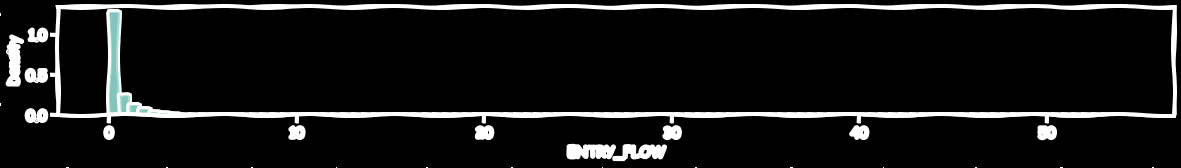

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_style("darkgrid") # darkgrid, whitegrid, dark, white, ticks
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
with plt.xkcd():
    plt.style.use("dark_background")
    plt.figure(figsize=[20,2])
    sns.histplot(mta_final['ENTRY_FLOW'], kde=False, bins=100, stat='density');

### Next, subset the data into pre-covid data and covid-data.
The plan here is to create flow measures for the various time blocks during pre-covid times and compare them to flow measures during covid. <br>
To do this, I'll have to subset the data, create the pre-covid 3-year averages by CA/UNIT, day, and time-block, and then merge these back into the covid-period data.

In [76]:
# Aggregate data by CA/UNIT, Day, and Time-block.
# Extract day
mta_final['day'] = mta_final['DATETIME'].dt.day

In [264]:
# print(f'Days run from {mta_final[mta_final.month == 7].day.min()} to {mta_final[mta_final.month == 7].day.max()}')

Days run from 1 to 31


In [77]:
mta_final['TIME_BLOCK'] = mta_final.TIME.apply(str)
#mta_final.TIME_BLOCK.value_counts()

08:00:00    304259
04:00:00    304145
20:00:00    303977
12:00:00    303950
16:00:00    303879
             ...  
11:58:15         1
06:03:36         1
17:41:19         1
23:03:50         1
22:57:00         1
Name: TIME_BLOCK, Length: 70677, dtype: int64

In [267]:
# a = mta_final[mta_final.TIME_BLOCK=='00:00:00'].shape[0]
# b = mta_final[mta_final.TIME_BLOCK=='04:00:00'].shape[0]
# c = mta_final[mta_final.TIME_BLOCK=='08:00:00'].shape[0]
# d = mta_final[mta_final.TIME_BLOCK=='12:00:00'].shape[0]
# e = mta_final[mta_final.TIME_BLOCK=='16:00:00'].shape[0]

# print(f"Total observations:   {mta_final.shape[0]:,}")
# print(f'Observations within 4-hour timeblocks: {a+b+c+d+e:,}')

Total observations:   3,578,042
Observations within 4-hour timeblocks: 1,520,151


In [78]:
mta_final.set_index(mta_final.DATETIME, inplace=True)

In [79]:
mta_final['TIME'] = pd.to_datetime(mta_final.TIME, format='%H:%M:%S')

def bintimes(time):
    if (time.hour >= 22) | (time.hour < 2):
        return '12:00-4:00 AM'
    if (time.hour >= 2) & (time.hour < 6):
        return '4:00-8:00 AM'
    elif (time.hour >= 6) & (time.hour < 10):
        return '8:00-12:00 AM'
    elif (time.hour >= 10) & (time.hour < 14):
        return '12:00-4:00 PM'
    elif (time.hour >= 14) & (time.hour < 18):
        return '4:00-8:00 PM'
    elif (time.hour >= 18) & (time.hour < 22):
        return '8:00-12:00 PM'
    else:
        return "oops"
    
mta_final['TIME_BLOCK'] = mta_final['DATETIME'].apply(bintimes)

In [80]:
# mta_final.TIME_BLOCK.value_counts()

8:00-12:00 AM    611844
12:00-4:00 PM    597432
4:00-8:00 PM     593459
8:00-12:00 PM    593040
4:00-8:00 AM     590329
12:00-4:00 AM    572840
Name: TIME_BLOCK, dtype: int64

In [190]:
mta_final['id1'] = mta_final.groupby(['CA', 'UNIT', 'SCP', 'STATION']).ngroup()
print(f"Total observations:   {mta_final.shape[0]:,}")
print("Unique Turnstyles:   ", mta_final.id.nunique())
print("Unique Stations:     ", mta_final['STATION'].nunique())
print("Unique Complex IDs:  ", mta_final['complex_id'].nunique())

Total observations:   3,558,944
Unique Turnstyles:    5116
Unique Stations:      379
Unique Complex IDs:   426


In [83]:
print(f"Total observations:   {mta_final.shape[0]:,}")
mta_timeblock = mta_final[mta_final.index.year==2020].groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "TIME_BLOCK"])[['ENTRIES_DELTA', 'EXITS_DELTA']].sum().reset_index()
print(f"Total observations after aggregating:   {mta_timeblock.shape[0]:,}")

print(f"Total observations:   {mta_final.shape[0]:,}")
mta_final['year'] = mta_final.index.year
mta_timeblock_pre = mta_final[mta_final.index.year<2020].groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "TIME_BLOCK", "year"])[['ENTRIES_DELTA', 'EXITS_DELTA']].sum().reset_index()
mta_timeblock_pre = mta_timeblock_pre.groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "TIME_BLOCK"])[['ENTRIES_DELTA', 'EXITS_DELTA']].mean().reset_index()
print(f"Total observations after aggregating:   {mta_timeblock.shape[0]:,}")

mta_timeblock_pre.rename(columns={'ENTRIES_DELTA': 'ENTRIES_PRE', 'EXITS_DELTA': 'EXITS_PRE'}, inplace=True) 
mta_timeblock = mta_timeblock.merge(mta_timeblock_pre, how='left', on=["complex_id", "GTFS Latitude", "GTFS Longitude", "TIME_BLOCK"])  

print(f'Observations with unreasonably high entry per day (pre-covid): {mta_timeblock[mta_timeblock.ENTRIES_PRE>(60*60*24)].shape[0]:,.0f}')
mta_timeblock = mta_timeblock[mta_timeblock.ENTRIES_PRE<(60*60*24)]
print(f'Observations with unreasonably high exit per day (pre-covid): {mta_timeblock[mta_timeblock.EXITS_PRE>(60*60*24)].shape[0]:,.0f}')
mta_timeblock = mta_timeblock[mta_timeblock.EXITS_PRE<(60*60*24)]
print(f'Observations with unreasonably high entry per day (during covid): {mta_timeblock[mta_timeblock.ENTRIES_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_timeblock = mta_timeblock[mta_timeblock.ENTRIES_DELTA<(60*60*24)]
print(f'Observations with unreasonably high exit per day (during covid): {mta_timeblock[mta_timeblock.EXITS_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_timeblock = mta_timeblock[mta_timeblock.EXITS_DELTA<(60*60*24)]
print(f"Total observations:   {mta_timeblock.shape[0]:,}")

print(f"Total observations:   {mta_timeblock.shape[0]:,}")
print("Unique Complex IDs:  ", mta_timeblock['complex_id'].nunique())

# Creating entries and exits as proportional to historical ridership:
mta_timeblock['ENTRIES_PCT'] = mta_timeblock.ENTRIES_DELTA / mta_timeblock.ENTRIES_PRE
mta_timeblock['EXITS_PCT'] = mta_timeblock.EXITS_DELTA / mta_timeblock.EXITS_PRE

Total observations:   3,558,944
Total observations after aggregating:   2,544
Total observations:   3,558,944
Total observations after aggregating:   2,544
Observations with unreasonably high entry per day (pre-covid): 373
Observations with unreasonably high exit per day (pre-covid): 73
Observations with unreasonably high entry per day (during covid): 0
Observations with unreasonably high exit per day (during covid): 0
Total observations:   2,098
Total observations:   2,098
Unique Complex IDs:   422


### Aggregating by day

In [84]:
mta_final['DATETIME_DELTA'] = mta_final.DATETIME_DELTA.astype(int)
mta_final['ENTRIES_DELTA'] = mta_final.ENTRIES_DELTA.astype(int)
mta_final['EXITS_DELTA'] = mta_final.EXITS_DELTA.astype(int)

print(f"Total observations:   {mta_final.shape[0]:,}")
mta_daily = mta_final.groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "DATE", "day", "month"])[['ENTRIES_DELTA', 'EXITS_DELTA']].sum().reset_index()
print(f"Total observations after aggregating by complex id:   {mta_daily.shape[0]:,}")

mta_daily["DATE"] = pd.to_datetime(mta_daily.DATE, format='%m/%d/%Y')
mta_daily.set_index("DATE", inplace=True)

Total observations:   3,558,944
Total observations after aggregating by complex id:   52,146


In [85]:
mta_daily_pre = mta_daily.loc['07/01/2017':'07/31/2019']
print(f"Total observations:   {mta_daily_pre.shape[0]:,}")
print(f"Start Date:           {mta_daily_pre.index.min():}")
print(f"End Date:             {mta_daily_pre.index.max():}")

Total observations:   39,006
Start Date:           2017-07-01 00:00:00
End Date:             2019-07-31 00:00:00


In [86]:
# Aggregating average daily value across years
mta_daily_pre = mta_daily_pre.groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "day", "month"])[['ENTRIES_DELTA', 'EXITS_DELTA']].mean().reset_index()
mta_daily_pre.rename(columns={'ENTRIES_DELTA': 'ENTRIES_PRE', 'EXITS_DELTA': 'EXITS_PRE'}, inplace=True)  
print(f"Total observations:   {mta_daily_pre.shape[0]:,}")         

Total observations:   13,175


In [87]:
# Merging these values back in with the 2020 data:
mta_daily = mta_daily.loc['07/01/2020':'07/31/2020']
print(f"Total observations:   {mta_daily.shape[0]:,}")
print(f"Start Date:           {mta_daily.index.min():}")
print(f"End Date:             {mta_daily.index.max():}")

Total observations:   13,140
Start Date:           2020-07-01 00:00:00
End Date:             2020-07-31 00:00:00


In [88]:
mta_daily = mta_daily.merge(mta_daily_pre, how='left', on=["complex_id", "GTFS Latitude", "GTFS Longitude", "day", "month"])  
print(f"Total observations:   {mta_daily.shape[0]:,}")

Total observations:   13,140


In [89]:
mta_daily['ENTRIES_PRE'] = mta_daily.ENTRIES_PRE.astype(int)
mta_daily['EXITS_PRE'] = mta_daily.EXITS_PRE.astype(int)
mta_daily['ENTRIES_DELTA'] = mta_daily.ENTRIES_DELTA.astype(int)
mta_daily['EXITS_DELTA'] = mta_daily.EXITS_DELTA.astype(int)

In [90]:
print(f'1 person per second would be {60*60*24:,.0f} per day')
print(f'Observations with unreasonably high entry per day: {mta_daily[mta_daily.ENTRIES_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_daily = mta_daily[mta_daily.ENTRIES_DELTA<(60*60*24)]
mta_daily['ENTRIES_DELTA'].describe()

1 person per second would be 86,400 per day
Observations with unreasonably high entry per day: 0


count   13140.00000
mean     2281.13326
std      2651.54910
min      -688.00000
25%       917.00000
50%      1561.00000
75%      2614.00000
max     29017.00000
Name: ENTRIES_DELTA, dtype: float64

In [91]:
print(f'1 person per second would be {60*60*24:,.0f} per day')
print(f'Observations with unreasonably high exit per day: {mta_daily[mta_daily.EXITS_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_daily = mta_daily[mta_daily.EXITS_DELTA<(60*60*24)]
mta_daily['EXITS_DELTA'].describe()

1 person per second would be 86,400 per day
Observations with unreasonably high exit per day: 0


count   13140.00000
mean     2452.88470
std      3263.64855
min         0.00000
25%       803.00000
50%      1528.00000
75%      2852.25000
max     39164.00000
Name: EXITS_DELTA, dtype: float64

In [92]:
print(f'1 person per second would be {60*60*24:,.0f} per day')
print(f'Observations with unreasonably high entry per day (pre-covid): {mta_daily[mta_daily.ENTRIES_PRE>(60*60*24)].shape[0]:,.0f}')
mta_daily = mta_daily[mta_daily.ENTRIES_PRE<(60*60*24)]
print(f'Observations with unreasonably high exits per day (pre-covid): {mta_daily[mta_daily.EXITS_PRE>(60*60*24)].shape[0]:,.0f}')
mta_daily = mta_daily[mta_daily.EXITS_PRE<(60*60*24)]

1 person per second would be 86,400 per day
Observations with unreasonably high entry per day (pre-covid): 117
Observations with unreasonably high exits per day (pre-covid): 7


In [93]:
# Creating entries and exits as proportional to historical ridership:
mta_daily['ENTRIES_PCT'] = mta_daily.ENTRIES_DELTA / mta_daily.ENTRIES_PRE
mta_daily['EXITS_PCT'] = mta_daily.EXITS_DELTA / mta_daily.EXITS_PRE
print(f"Total observations:   {mta_daily.shape[0]:,}")

Total observations:   13,016


In [94]:
# Cutting values to between the first and 99th percentiles:
print(f"1st percentile:       {mta_daily.ENTRIES_PCT.quantile(q=0.01):,.3f}")
print(f"99th percentile:      {mta_daily.ENTRIES_PCT.quantile(q=0.99):,.3f}")
print(f"Total observations:   {mta_daily.shape[0]:,}")
mta_daily = mta_daily[(mta_daily.ENTRIES_PCT < mta_daily.ENTRIES_PCT.quantile(q=0.99)) & (mta_daily.ENTRIES_PCT > mta_daily.ENTRIES_PCT.quantile(q=0.01))]
print(f"Total observations:   {mta_daily.shape[0]:,}") 

# Cutting values to between the first and 99th percentiles:
print(f"1st percentile:       {mta_daily.EXITS_PCT.quantile(q=0.01):,.3f}")
print(f"99th percentile:      {mta_daily.EXITS_PCT.quantile(q=0.99):,.3f}")
print(f"Total observations:   {mta_daily.shape[0]:,}")
mta_daily = mta_daily[(mta_daily.EXITS_PCT < mta_daily.EXITS_PCT.quantile(q=0.99)) & (mta_daily.EXITS_PCT > mta_daily.EXITS_PCT.quantile(q=0.01))]
print(f"Total observations:   {mta_daily.shape[0]:,}")  

In [195]:
print(f"75th percentile of entries:      {100*mta_daily.ENTRIES_PCT.quantile(q=0.75):,.3f}%")
print(f"50th percentile of entries:      {100*mta_daily.ENTRIES_PCT.quantile(q=0.50):,.3f}%")
print(f"25th percentile of entries:      {100*mta_daily.ENTRIES_PCT.quantile(q=0.25):,.3f}%")
print(f"75th percentile of exits:        {100*mta_daily.EXITS_PCT.quantile(q=0.75):,.3f}%")
print(f"50th percentile of exits:        {100*mta_daily.EXITS_PCT.quantile(q=0.50):,.3f}%")
print(f"25th percentile of exits:        {100*mta_daily.EXITS_PCT.quantile(q=0.25):,.3f}%")

75th percentile of entries:      38.952%
50th percentile of entries:      28.202%
25th percentile of entries:      18.424%
75th percentile of exits:        53.670%
50th percentile of exits:        39.533%
25th percentile of exits:        26.903%


## Aggregating by day of the week

In [95]:
mta_final['dow'] = mta_final.index.day_name()

print(f"Total observations:   {mta_final.shape[0]:,}")
mta_dow = mta_final[mta_final.index.year==2020].groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "dow"])[['ENTRIES_DELTA', 'EXITS_DELTA']].sum().reset_index()
print(f"Total observations after aggregating:   {mta_dow.shape[0]:,}")

Total observations:   3,558,944
Total observations after aggregating:   2,968


In [96]:
print(f"Total observations:   {mta_final.shape[0]:,}")
mta_final['year'] = mta_final.index.year
mta_dow_pre = mta_final[mta_final.index.year<2020].groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "dow", "year"])[['ENTRIES_DELTA', 'EXITS_DELTA']].sum().reset_index()
mta_dow_pre = mta_dow_pre.groupby(["complex_id", "GTFS Latitude", "GTFS Longitude", "dow"])[['ENTRIES_DELTA', 'EXITS_DELTA']].mean().reset_index()
print(f"Total observations after aggregating:   {mta_dow.shape[0]:,}")
mta_dow_pre.rename(columns={'ENTRIES_DELTA': 'ENTRIES_PRE', 'EXITS_DELTA': 'EXITS_PRE'}, inplace=True) 
mta_dow = mta_dow.merge(mta_dow_pre, how='left', on=["complex_id", "GTFS Latitude", "GTFS Longitude", "dow"])  

Total observations:   3,558,944
Total observations after aggregating:   2,968


In [97]:
print(f'Observations with unreasonably high entry per day (pre-covid): {mta_dow[mta_dow.ENTRIES_PRE>(60*60*24)].shape[0]:,.0f}')
mta_dow = mta_dow[mta_dow.ENTRIES_PRE<(60*60*24)]
print(f'Observations with unreasonably high exit per day (pre-covid): {mta_dow[mta_dow.EXITS_PRE>(60*60*24)].shape[0]:,.0f}')
mta_dow = mta_dow[mta_dow.EXITS_PRE<(60*60*24)]
print(f'Observations with unreasonably high entry per day (during covid): {mta_dow[mta_dow.ENTRIES_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_dow = mta_dow[mta_dow.ENTRIES_DELTA<(60*60*24)]
print(f'Observations with unreasonably high exit per day (during covid): {mta_dow[mta_dow.EXITS_DELTA>(60*60*24)].shape[0]:,.0f}')
mta_dow = mta_dow[mta_dow.EXITS_DELTA<(60*60*24)]
print(f"Total observations:   {mta_dow.shape[0]:,}")

# Creating entries and exits as proportional to historical ridership:
mta_dow['ENTRIES_PCT'] = mta_dow.ENTRIES_DELTA / mta_dow.ENTRIES_PRE
mta_dow['EXITS_PCT'] = mta_dow.EXITS_DELTA / mta_dow.EXITS_PRE

Observations with unreasonably high entry per day (pre-covid): 332
Observations with unreasonably high exit per day (pre-covid): 9
Observations with unreasonably high entry per day (during covid): 0
Observations with unreasonably high exit per day (during covid): 0
Total observations:   2,627


In [98]:
# Cutting values to between the first and 99th percentiles:
print(f"1st percentile:       {mta_dow.ENTRIES_PCT.quantile(q=0.01):,.3f}")
print(f"99th percentile:      {mta_dow.ENTRIES_PCT.quantile(q=0.99):,.3f}")
print(f"Total observations:   {mta_dow.shape[0]:,}")
mta_dow = mta_dow[(mta_dow.ENTRIES_PCT < mta_dow.ENTRIES_PCT.quantile(q=0.99)) & (mta_dow.ENTRIES_PCT > mta_dow.ENTRIES_PCT.quantile(q=0.01))]
print(f"Total observations:   {mta_dow.shape[0]:,}") 

# Cutting values to between the first and 99th percentiles:
print(f"1st percentile:       {mta_dow.EXITS_PCT.quantile(q=0.01):,.3f}")
print(f"99th percentile:      {mta_dow.EXITS_PCT.quantile(q=0.99):,.3f}")
print(f"Total observations:   {mta_dow.shape[0]:,}")
mta_dow = mta_dow[(mta_dow.EXITS_PCT < mta_dow.EXITS_PCT.quantile(q=0.99)) & (mta_dow.EXITS_PCT > mta_dow.EXITS_PCT.quantile(q=0.01))]
print(f"Total observations:   {mta_dow.shape[0]:,}")  

1st percentile:       0.010
99th percentile:      0.680
Total observations:   2,627
Total observations:   2,573
1st percentile:       0.087
99th percentile:      0.838
Total observations:   2,573
Total observations:   2,514


## Examining trends in proportional ridership changes:

In [288]:
mta_daily.sort_values(by=['ENTRIES_PCT', 'complex_id', 'day', 'month'], inplace=True, ignore_index=True)
mta_daily.reset_index(drop=True, inplace=True)

In [290]:
mta_daily[mta_daily.ENTRIES_PCT > 0].ENTRIES_PCT.describe()

count    12439.000000
mean         0.296654
std          0.140876
min          0.012484
25%          0.186329
50%          0.283263
75%          0.389337
max          0.806183
Name: ENTRIES_PCT, dtype: float64

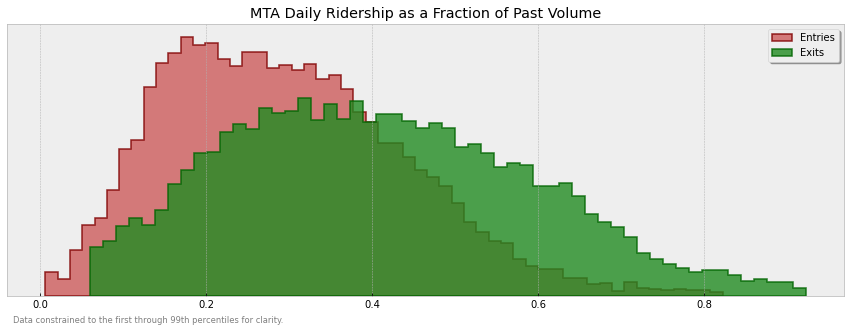

In [99]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(mta_daily.ENTRIES_PCT, histtype="stepfilled", bins=55, alpha=0.8, density=True, facecolor='indianred', edgecolor='maroon', linewidth=1.6)
ax.hist(mta_daily.EXITS_PCT.dropna().values, histtype="stepfilled", bins=55, alpha=0.8, density=True, facecolor='forestgreen', edgecolor='darkgreen', linewidth=1.6)

ax.set_title("MTA Daily Ridership as a Fraction of Past Volume")
plt.legend(['Entries','Exits'],shadow = True, loc = 0)
ax.yaxis.set_visible(False)
plt.figtext(0.13, 0.05, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')
plt.savefig('mta_daily.png');

In [100]:
# Quick reshape to use the "hue" function in seaborn violin plot
mta_dowgr = mta_dow.loc[:,('dow', 'complex_id', 'ENTRIES_PCT')]
mta_dowgr.rename(columns={'ENTRIES_PCT': 'PCT'}, inplace=True)
mta_dowgr['Legend'] = 'Entries'
mta_dowgr.head()

mta_dowgr2 = mta_dow.loc[:,('dow', 'complex_id', 'EXITS_PCT')]
mta_dowgr2.rename(columns={'EXITS_PCT': 'PCT'}, inplace=True)
mta_dowgr2['Legend'] = 'Exits'
mta_dowgr2.head()
mta_dowgr3 = mta_dowgr.append(mta_dowgr2)

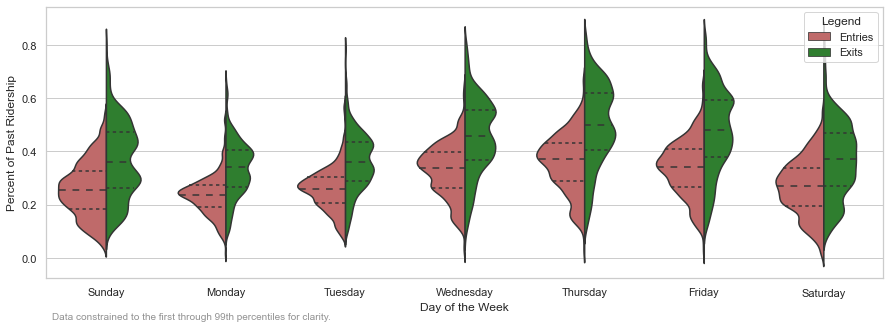

In [106]:
import seaborn as sns
my_pal = {"Exits": 'forestgreen', "Entries": 'indianred'}

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.violinplot(x='dow', 
                    y='PCT', 
                    hue='Legend', 
                    bw=.2,
                    data=mta_dowgr3, 
                    split=True,
                    order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
                    palette=my_pal,
                    inner="quartile")
plt.xlabel("Day of the Week")
plt.ylabel("Percent of Past Ridership")
plt.figtext(0.13, 0.01, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')
plt.savefig('mta_dow.png')

In [108]:
# Quick reshape to use the "hue" function in seaborn violin plot
mta_timeblockgr = mta_timeblock.loc[:,('TIME_BLOCK', 'complex_id', 'ENTRIES_PCT')]
mta_timeblockgr.rename(columns={'ENTRIES_PCT': 'PCT'}, inplace=True)
mta_timeblockgr['Legend'] = 'Entries'
mta_timeblockgr.head()

mta_timeblockgr2 = mta_timeblock.loc[:,('TIME_BLOCK', 'complex_id', 'EXITS_PCT')]
mta_timeblockgr2.rename(columns={'EXITS_PCT': 'PCT'}, inplace=True)
mta_timeblockgr2['Legend'] = 'Exits'
mta_timeblockgr2.head()
mta_timeblockgr3 = mta_timeblockgr.append(mta_timeblockgr2)

In [109]:
# Cutting values to between the first and 99th percentiles:
print(f"1st percentile:       {mta_timeblockgr3.PCT.quantile(q=0.01):,.3f}")
print(f"99th percentile:      {mta_timeblockgr3.PCT.quantile(q=0.99):,.3f}")
print(f"Total observations:   {mta_timeblockgr3.shape[0]:,}")
mta_timeblockgr3 = mta_timeblockgr3[(mta_timeblockgr3.PCT < mta_timeblockgr3.PCT.quantile(q=0.99)) & (mta_timeblockgr3.PCT > mta_timeblockgr3.PCT.quantile(q=0.01))]
print(f"Total observations:   {mta_timeblockgr3.shape[0]:,}") 

1st percentile:       0.022
99th percentile:      0.807
Total observations:   4,196
Total observations:   4,105


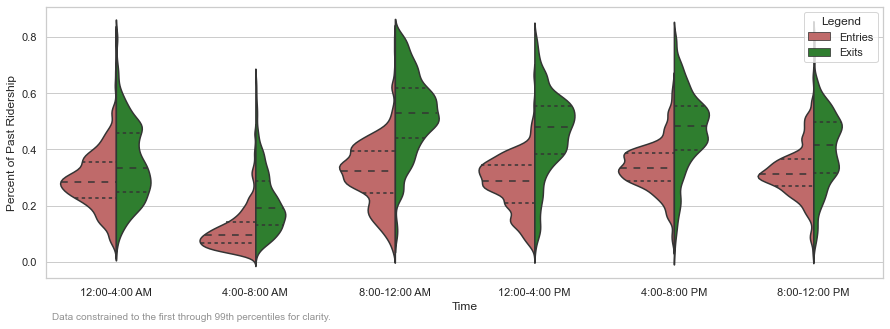

In [112]:
import seaborn as sns
my_pal = {"Exits": 'forestgreen', "Entries": 'indianred'}

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.violinplot(x='TIME_BLOCK', 
                    y='PCT', 
                    hue='Legend', 
                    data=mta_timeblockgr3, 
                    bw=.2,
                    inner='quartile',
                    split=True,
                    order=['12:00-4:00 AM','4:00-8:00 AM','8:00-12:00 AM','12:00-4:00 PM','4:00-8:00 PM','8:00-12:00 PM'],
                    palette=my_pal)
plt.xlabel("Time")
plt.ylabel("Percent of Past Ridership")
plt.figtext(0.13, 0.01, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')
plt.savefig('mta_timeblock.png')

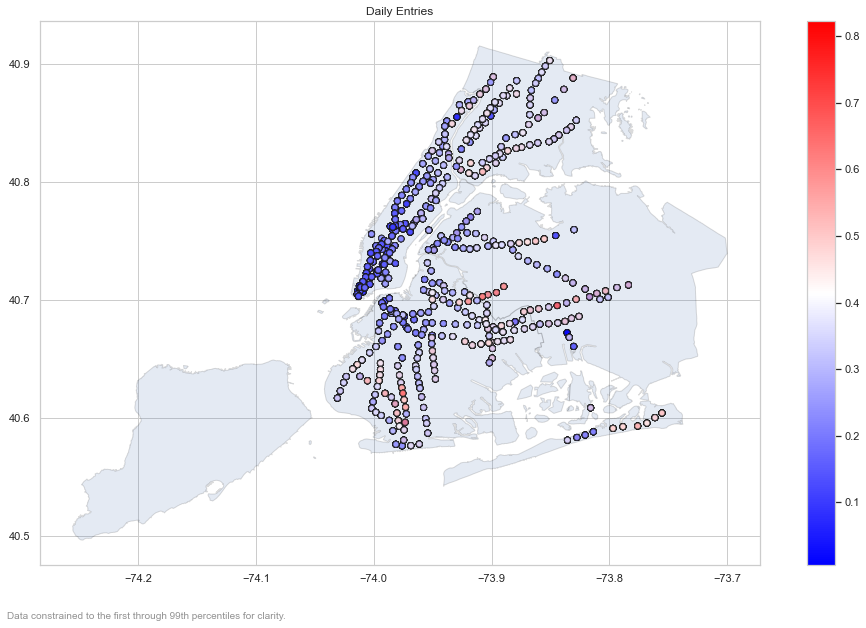

In [188]:
import geopandas as gpd
import geoplot as gplt
#usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
#usa_cities.head()
#continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')
#gplt.pointplot(usa_cities)

# Import as geopandas dataframe and convert the lat/long to geometry
mta_daily = gpd.GeoDataFrame(mta_daily, geometry=gpd.points_from_xy(mta_daily['GTFS Longitude'], mta_daily['GTFS Latitude']))
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

import contextily as ctx
#fig, ax = plt.subplots()
#nyc_boroughs = nyc_boroughs.to_crs(epsg=3857)

ax.set_aspect('equal')
base = nyc_boroughs.plot( figsize=(17, 10), alpha=0.15, edgecolor='k')
mta_daily.plot(ax=base, figsize=(10, 10), alpha=0.5, edgecolor='k', column='ENTRIES_PCT', cmap='bwr', legend=True);
plt.figtext(0.13, 0.05, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')
plt.title("Daily Entries")
plt.savefig('mta_daily_ent_map.png');

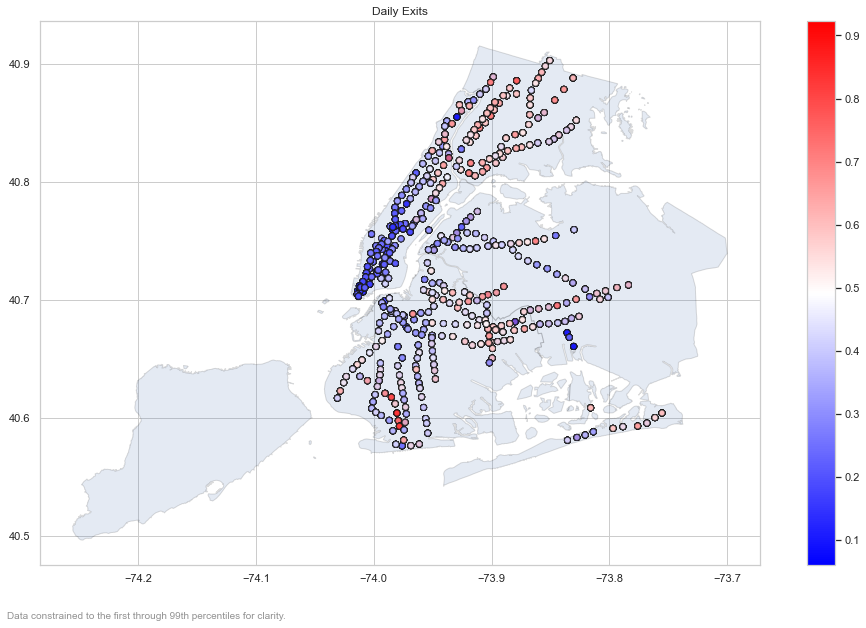

In [115]:
# Import as geopandas dataframe and convert the lat/long to geometry
mta_daily = gpd.GeoDataFrame(mta_daily, geometry=gpd.points_from_xy(mta_daily['GTFS Longitude'], mta_daily['GTFS Latitude']))
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

ax.set_aspect('equal')
base = nyc_boroughs.plot( figsize=(17, 10), alpha=0.15, edgecolor='k')
mta_daily.plot(ax=base, figsize=(10, 10), alpha=0.5, edgecolor='k', column='EXITS_PCT', cmap='bwr', legend=True);
plt.figtext(0.13, 0.05, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')
plt.title("Daily Exits")
plt.savefig('mta_daily_ext_map.png');

In [116]:
mta_dow.dow.value_counts()

Sunday       375
Saturday     374
Friday       359
Wednesday    354
Thursday     354
Tuesday      349
Monday       349
Name: dow, dtype: int64

In [117]:
# Import as geopandas dataframe and convert the lat/long to geometry
mta_dow = gpd.GeoDataFrame(mta_dow, geometry=gpd.points_from_xy(mta_dow['GTFS Longitude'], mta_dow['GTFS Latitude']))

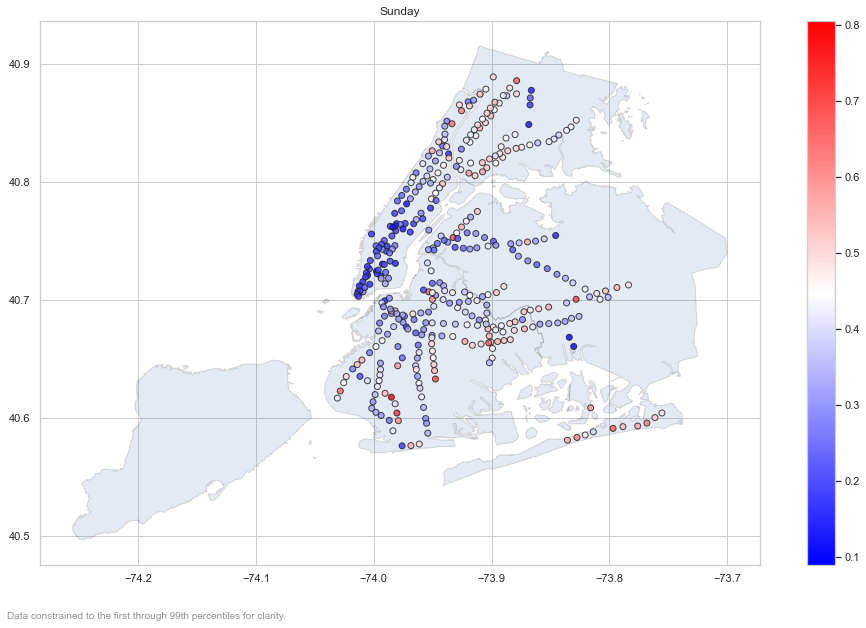

In [146]:
mta_dow0 = mta_dow[mta_dow.loc[:,'dow']=='Sunday']
base = nyc_boroughs.plot( figsize=(17, 10), alpha=0.15, edgecolor='k')
mta_dow0.plot(ax=base, figsize=(10, 10), alpha=0.8, edgecolor='k', column='EXITS_PCT', cmap='bwr', legend=True);
plt.figtext(0.13, 0.05, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')

plt.title("Sunday")
plt.savefig('mta_dow0_map.png');

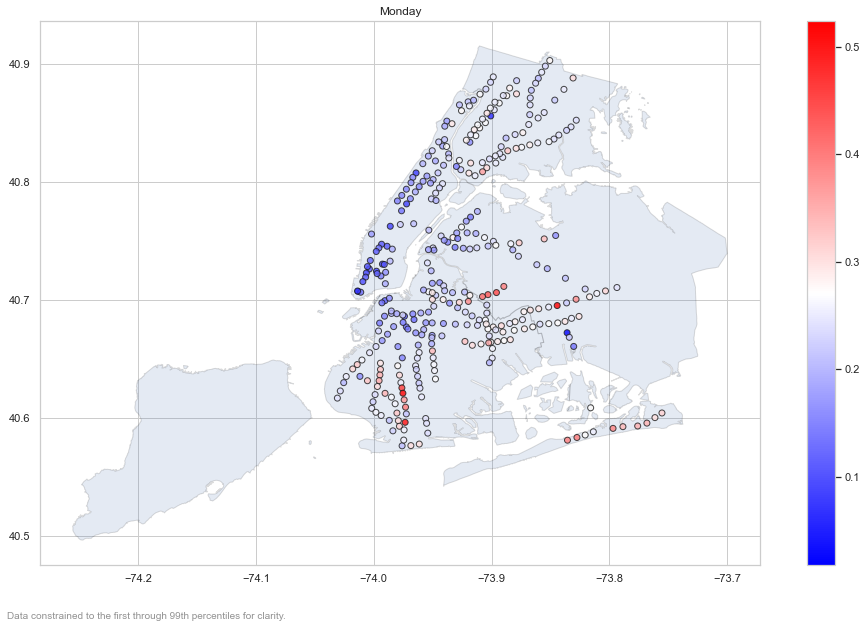

In [149]:
mta_dow1 = mta_dow[mta_dow.loc[:,'dow']=='Monday']
base = nyc_boroughs.plot( figsize=(17, 10), alpha=0.15, edgecolor='k')
mta_dow1.plot(ax=base, figsize=(10, 10), alpha=0.8, edgecolor='k', column='ENTRIES_PCT', cmap='bwr', legend=True);
plt.figtext(0.13, 0.05, 'Data constrained to the first through 99th percentiles for clarity.', horizontalalignment='left', alpha=0.5, fontsize='small')

plt.title("Monday")
plt.savefig('mta_dow1_map.png');

In [177]:
mta_dow['ent_norm'] = mta_dow.groupby('dow')['ENTRIES_PCT'].transform(lambda x: (x - x.mean()) / x.std())

In [179]:
mta_dow0 = mta_dow[mta_dow.loc[:,'dow']=='Sunday']
mta_dow1 = mta_dow[mta_dow.loc[:,'dow']=='Monday']
mta_dow2 = mta_dow[mta_dow.loc[:,'dow']=='Tuesday']
mta_dow3 = mta_dow[mta_dow.loc[:,'dow']=='Wednesday']
mta_dow4 = mta_dow[mta_dow.loc[:,'dow']=='Thursday']
mta_dow5 = mta_dow[mta_dow.loc[:,'dow']=='Friday']
mta_dow6 = mta_dow[mta_dow.loc[:,'dow']=='Saturday']

In [180]:
mta_dow0.ent_norm.describe()

count   375.00000
mean     -0.00000
std       1.00000
min      -2.07644
25%      -0.73083
50%      -0.01549
75%       0.66867
max       2.76779
Name: ent_norm, dtype: float64

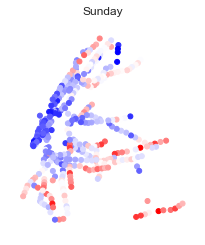

In [181]:
gplt.pointplot(mta_dow0['geometry'], hue=mta_dow0.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Sunday")
plt.savefig('mta_dow0_map.png');

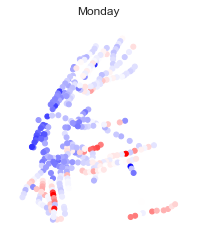

In [182]:
gplt.pointplot(mta_dow1['geometry'], hue=mta_dow1.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Monday")
plt.savefig('mta_dow1_map.png');

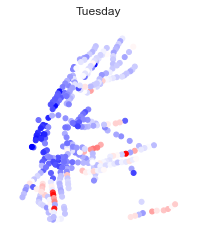

In [183]:
gplt.pointplot(mta_dow2['geometry'], hue=mta_dow2.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Tuesday")
plt.savefig('mta_dow2_map.png');

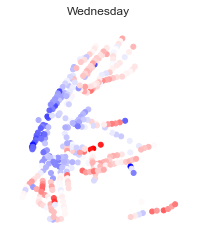

In [184]:
gplt.pointplot(mta_dow3['geometry'], hue=mta_dow3.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Wednesday")
plt.savefig('mta_dow3_map.png');

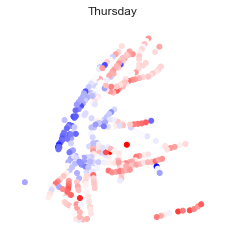

In [185]:
gplt.pointplot(mta_dow4['geometry'], hue=mta_dow4.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Thursday")
plt.savefig('mta_dow4_map.png');

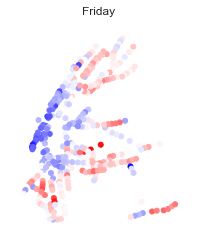

In [186]:
gplt.pointplot(mta_dow5['geometry'], hue=mta_dow5.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Friday")
plt.savefig('mta_dow5_map.png');

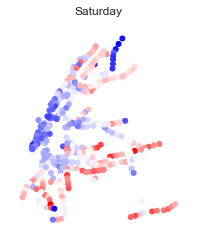

In [187]:
gplt.pointplot(mta_dow6['geometry'], hue=mta_dow6.ENTRIES_PCT, cmap='bwr', figsize=(7, 4))
plt.title("Saturday")
plt.savefig('mta_dow6_map.png');